# Active Learning Pipeline Showcase Peony Project

### Import Peony Packages

In [1]:
from PeonyPackage.PeonyDb import MongoDb
from Peony_visualization.src.peony_visualization import calculate_binary_metrics
from Peony_box.src.peony_box_model import PeonyBoxModel
from Peony_box.src.transformators.HuffPost_transformator import HuffPostTransform as transformator
from Peony_box.src.transformators.HuffPost_transformator import HuffPostTransformWordEmbeddings as word_embed_transformator
from Peony_database.src.datasets.HuffPost_news_dataset import (
    COLLECTION_NAME as HuffPost_collection_name,
    COLLECTION_ID as HuffPost_collection_id,
)
from Peony_box.src.utils import k_fold_corss_validation, auc_metrics
from Peony_box.src.acquisition_functions.functions import entropy_sampling, false_positive_sampling
from Peony_visualization.src.peony_visualization import visualize_two_auc_evolutions

### Import Other Packages

In [2]:
import numpy as np
import multiprocessing as mp

from IPython.utils import io
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle

## Create Peony Databse API

In [3]:
api = MongoDb()

## Get articles and labebls from Peony Databse

In [4]:
sport_records = api.get_record(
    collection_name=HuffPost_collection_name,
    collection_id=HuffPost_collection_id,
    label="SPORTS",
    limit=500,
)

comedy_records = api.get_record(
    collection_name=HuffPost_collection_name,
    collection_id=HuffPost_collection_id,
    label="COMEDY",
    limit=500,
)

instances = sport_records + comedy_records
labels = [sample["record"]["label"] for sample in sport_records + comedy_records]

instances_from_db, labels_from_db = shuffle(instances, labels, random_state=0)

## Create and Fit Transformator

### TF-IDF Bag-of-words based transformator

In [5]:
HuffPostTransform = transformator()
HuffPostTransform.fit(instances_from_db, labels_from_db)

100%|██████████| 1000/1000 [00:00<00:00, 31917.21it/s]

transforming data...


creating labels encoding hash map...


### Fast Text Word Embeddings

In [6]:
HuffPostWordEmbeddingsTransform = word_embed_transformator()
HuffPostWordEmbeddingsTransform.fit(instances_from_db, labels_from_db)

100%|██████████| 1000/1000 [00:00<00:00, 103059.22it/s]

transforming data...



  0%|          | 32/20405 [00:00<01:03, 318.44it/s]

creating (words -> embeddings) hash map...


100%|██████████| 20405/20405 [00:38<00:00, 523.62it/s]

creating labels encoding hash map...


## TF-IDF Bag-of-words Based Active Learning Performance

### Tranform All Instances (TF-IDF Bag-of-words) For Faster Computations

In [7]:
instances = HuffPostTransform.transform_instances(instances_from_db).toarray()
labels = HuffPostTransform.transform_labels(labels_from_db)

100%|██████████| 1000/1000 [00:00<00:00, 1584550.06it/s]


### Methods for Active Learning Pipeline Simulation (valid for any encoding)

In [8]:
def reset_validation_data(testing_instances, 
                          testing_labels, 
                          new_training_indices):
    new_training_indices = new_training_indices.tolist()
    training_instances = [testing_instances[index] for index in new_training_indices]
    training_labels = [testing_labels[index] for index in new_training_indices]
    testing_instances = np.delete(testing_instances, new_training_indices, axis=0)
    testing_labels = np.delete(testing_labels, new_training_indices, axis=None)

    return training_instances, training_labels, testing_instances, testing_labels
    
def active_learning_simulation(transformator, acquisition_function, active_learning_loops, max_active_learning_iters, active_learning_step, model):
    
    #pool = mp.Pool(mp.cpu_count())
    
    # Repeat experiment for statistical validation
    # Return auc results for all runs and different active learning iteration
    
    #result = [pool.apply(active_learning_simulation_round, args = (transformator, acquisition_function, max_active_learning_iters, active_learning_step, model)) for _ in range(active_learning_loops)]
    
    #pool.close()
    
    result = [active_learning_simulation_round(transformator, acquisition_function, max_active_learning_iters, active_learning_step, model) for _ in tqdm(range(active_learning_loops))]
    
    return result
    
    
    
def active_learning_simulation_round(transformator, acquisition_function, max_active_learning_iters, active_learning_step, model):
    auc_active_learning_runs = []
    #Data preparation
    auc_active_learning = []

    training_instances = instances[:initial_training_data_size]
    training_labels = labels[:initial_training_data_size]

    testing_instances = instances[initial_training_data_size:]
    testing_labels = labels[initial_training_data_size:]

    #Active Learning Pipeline Run
    peony_model = PeonyBoxModel(transformator, active_learning_step=active_learning_step, acquisition_function = acquisition_function)
    with io.capture_output() as captured: #suppressing output
        #Fit model with very little set of training data
        if model == "svm":
            peony_model.svm_model.fit(training_instances, training_labels, False);
        elif model == "nn":
            peony_model.feed_forward_nn.fit(training_instances, training_labels, False);
        elif model == "bayesian_sgld":
            peony_model.bayesian_sgld_nn.fit(training_instances, training_labels, False);
        else:
            peony_model.random_forest_model.fit(training_instances, training_labels, False);

    #Start active learning loop
    for index in (range(max_active_learning_iters)):
        with io.capture_output() as captured: #suppressing output

            #predict the dataset complement for choosing next training data
            if model == "svm":
                predicted = peony_model.svm_model.predict(testing_instances, False);
            elif model == "nn":
                predicted = peony_model.feed_forward_nn.predict(testing_instances, False);
            elif model == "bayesian_sgld":
                predicted = peony_model.bayesian_sgld_nn.predict(testing_instances, False);
            else:
                predicted = peony_model.random_forest_model.predict(testing_instances, False);

            labels_for_auc = testing_labels;
            auc_active_learning.append(auc_metrics([{"true": labels_for_auc, "predicted": predicted}]))

            #Get indices based on acquisition function
            if model == "svm":
                indices = peony_model.svm_model.get_learning_samples(testing_instances, False)
            elif model == "nn":
                indices = peony_model.feed_forward_nn.get_learning_samples(testing_instances, False)
            elif model == "bayesian_sgld":
                indices = peony_model.bayesian_sgld_nn.get_learning_samples(testing_instances, False)
            else:
                indices = peony_model.random_forest_model.get_learning_samples(testing_instances, False)

            #Reset validation dataset (add training data, remove testing data)
            training_instances, training_labels, testing_instances, testing_labels = reset_validation_data(testing_instances, testing_labels, indices)

            #Add new learning samples to the model and retrain
            if model == "svm":
                peony_model.svm_model.add_new_learning_samples(training_instances, training_labels, False);
            elif model == "nn":
                peony_model.feed_forward_nn.add_new_learning_samples(training_instances, training_labels, False);
            elif model == "bayesian_sgld":
                peony_model.bayesian_sgld_nn.add_new_learning_samples(training_instances, training_labels, False);
            else:
                peony_model.random_forest_model.add_new_learning_samples(training_instances, training_labels, False);
            
    return auc_active_learning

### Random Forest Active Learning (Entropy vs Random Sampling)


### Active Learning Pipeline

#### Random Training Data Sampling

In [ ]:
#Define model specifications
model = "random_forest"
acquisition_function = "random"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_random_10_runs = active_learning_simulation(HuffPostTransform, None, active_learning_loops, max_active_learning_iters, active_learning_step, "random_forest")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_random_10_runs]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

#### False Positive Approach Training Data Sampling

In [ ]:
#Define model specifications
model = "random_forest"
acquisition_function = "false_positive_sampling"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_false_positive_10_runs = active_learning_simulation(HuffPostTransform, false_positive_sampling, active_learning_loops, max_active_learning_iters, active_learning_step, "random_forest")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_false_positive_10_runs]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

### SVM Active Learning (Entropy vs Random Sampling)

### Active Learning Pipeline

#### Random Training Data Sampling

In [ ]:
#Define model specifications
model = "svm"
acquisition_function = "random"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_random_10_runs_svm = active_learning_simulation(HuffPostTransform, None, active_learning_loops, max_active_learning_iters, active_learning_step, "svm")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_random_10_runs_svm]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

#### False Positive Approach Training Data Sampling

In [ ]:
#Define model specifications
model = "svm"
acquisition_function = "false_positive_sampling"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_false_positive_10_runs_svm = active_learning_simulation(HuffPostTransform, false_positive_sampling, active_learning_loops, max_active_learning_iters, active_learning_step, "svm")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_false_positive_10_runs_svm]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

## Extracting results from Peony Database

### SVM Results and Visualization

#### Results

In [8]:
#Random acquisition function 
svm_random_sampling_results = api.get_model_results({"model": "svm", "acquisition_function": "random"})
svm_random_sampling_results = [item for val in svm_random_sampling_results for item in val["results"]]

#Entropy acquisition function
svm_false_positive_sampling_results = api.get_model_results({"model": "svm", "acquisition_function": "false_positive_sampling"})
svm_false_positive_sampling_results = [item for val in svm_false_positive_sampling_results for item in val["results"]]

#we use zero index because database returns list even if it is only one element in list

#### Visualization

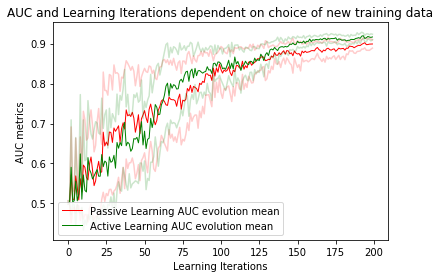

In [9]:
visualize_two_auc_evolutions(svm_random_sampling_results, svm_false_positive_sampling_results)

### Random Forest Results and Visualization

#### Results

In [10]:
#Random acquisition function 
random_forest_random_sampling_results = api.get_model_results({"model": "random_forest", "acquisition_function": "random"})
random_forest_random_sampling_results = [item for val in random_forest_random_sampling_results for item in val["results"]]

#Entropy acquisition function
random_forest_false_positive_sampling_results = api.get_model_results({"model": "random_forest", "acquisition_function": "false_positive_sampling"})
random_forest_false_positive_sampling_results = [item for val in random_forest_false_positive_sampling_results for item in val["results"]]

#we use zero index because database returns list even if it is only one element in list

#### Visualization

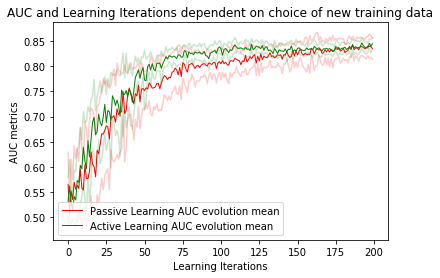

In [11]:
visualize_two_auc_evolutions(random_forest_random_sampling_results, random_forest_false_positive_sampling_results)

## Fast Text Words Embeddings Based Active Learning Performance

### Tranform All Instances (Fast Text Words Embeddings) For Faster Computations

In [9]:
instances = np.asarray(HuffPostWordEmbeddingsTransform.transform_instances(instances_from_db))
labels = HuffPostWordEmbeddingsTransform.transform_labels(labels_from_db)

100%|██████████| 1000/1000 [00:00<00:00, 1426634.01it/s]


### Random Forest Active Learning (Entropy vs Random Sampling)

### Active Learning Pipeline

#### Random Training Data Sampling

In [18]:
#Define model specifications
model = "random_forest_fast_text_embeddings"
acquisition_function = "random"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_random_10_runs = active_learning_simulation(HuffPostWordEmbeddingsTransform, None, active_learning_loops, max_active_learning_iters, active_learning_step, "random_forest")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_random_10_runs]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

#### False Positive Approach Training Data Sampling

In [20]:
#Define model specifications
model = "random_forest_fast_text_embeddings"
acquisition_function = "false_positive_sampling"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_false_positive_10_runs = active_learning_simulation(HuffPostWordEmbeddingsTransform, false_positive_sampling, active_learning_loops, max_active_learning_iters, active_learning_step, "random_forest")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_false_positive_10_runs]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

### SVM Active Learning (Entropy vs Random Sampling)

### Active Learning Pipeline

#### Random Training Data Sampling

In [27]:
#Define model specifications
model = "svm_fast_text_embeddings"
acquisition_function = "random"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_random_10_runs_svm = active_learning_simulation(HuffPostWordEmbeddingsTransform, None, active_learning_loops, max_active_learning_iters, active_learning_step, "svm")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_random_10_runs_svm]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

#### False Positive Approach Training Data Sampling

In [ ]:
#Define model specifications
model = "svm_fast_text_embeddings"
acquisition_function = "false_positive_sampling"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_false_positive_10_runs_svm = active_learning_simulation(HuffPostWordEmbeddingsTransform, false_positive_sampling, active_learning_loops, max_active_learning_iters, active_learning_step, "svm")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_false_positive_10_runs_svm]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

### Feed Forward NN Active Learning (Entropy vs Random Sampling)

### Active Learning Pipeline

#### Random Training Data Sampling

In [9]:
#Define model specifications
model = "feed_forward_nn_fast_text_embeddings"
acquisition_function = "random"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_random_10_runs_nn = active_learning_simulation(HuffPostWordEmbeddingsTransform, None, active_learning_loops, max_active_learning_iters, active_learning_step, "nn")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_random_10_runs_nn]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

#### False Positive Approach Training Data Sampling

In [10]:
#Define model specifications
model = "feed_forward_nn_fast_text_embeddings"
acquisition_function = "false_positive_sampling"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_false_positive_10_runs_nn = active_learning_simulation(HuffPostWordEmbeddingsTransform, false_positive_sampling, active_learning_loops, max_active_learning_iters, active_learning_step, "nn")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_false_positive_10_runs_nn]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

### Bayesian SGLD Feed Forward NN Active Learning (Entropy vs Random Sampling)

### Active Learning Pipeline

#### Random Training Data Sampling

In [ ]:
#Define model specifications
model = "feed_forward_nn_fast_text_embeddings"
acquisition_function = "random"
active_learning_loops = 10
active_learning_step = 1
max_active_learning_iters = 200
initial_training_data_size = 10
validation_data_size = 1000
category_1 = "SPORTS"
category_2 = "COMEDY"

#Get AUC results from an active learning simulation  
auc_active_learning_random_10_runs_bayesian_sgld = active_learning_simulation(HuffPostWordEmbeddingsTransform, None, active_learning_loops, max_active_learning_iters, active_learning_step, "bayesian_sgld")

#Pack specifications and resutls to the list for uploading to Peony Database 
list_to_upload = [model, acquisition_function, active_learning_loops, active_learning_step, max_active_learning_iters, initial_training_data_size, validation_data_size, category_1, category_2, auc_active_learning_random_10_runs_bayesian_sgld]

#Upload results to Peony Database
api.load_model_results(*list_to_upload)

## Extracting results from Peony Database

### SVM Results and Visualization

#### Results

In [53]:
#Random acquisition function 
svm_random_sampling_results = api.get_model_results({"model": "svm_fast_text_embeddings", "acquisition_function": "random"})
svm_random_sampling_results = [item for val in svm_random_sampling_results for item in val["results"]]

#Entropy acquisition function
svm_false_positive_sampling_results = api.get_model_results({"model": "svm_fast_text_embeddings", "acquisition_function": "false_positive_sampling"})
svm_false_positive_sampling_results = [item for val in svm_false_positive_sampling_results for item in val["results"]]

#we use zero index because database returns list even if it is only one element in list

#### Visualization

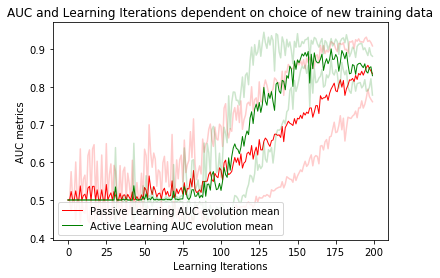

In [54]:
visualize_two_auc_evolutions(svm_random_sampling_results, svm_false_positive_sampling_results)

### Random Forest Results and Visualization

In [55]:
#Random acquisition function 
random_forest_random_sampling_results = api.get_model_results({"model": "random_forest_fast_text_embeddings", "acquisition_function": "random"})
random_forest_random_sampling_results = [item for val in random_forest_random_sampling_results for item in val["results"]]

#Entropy acquisition function
random_forest_false_positive_sampling_results = api.get_model_results({"model": "random_forest_fast_text_embeddings", "acquisition_function": "false_positive_sampling"})
random_forest_false_positive_sampling_results = [item for val in random_forest_false_positive_sampling_results for item in val["results"]]

#we use zero index because database returns list even if it is only one element in list

#### Visualization

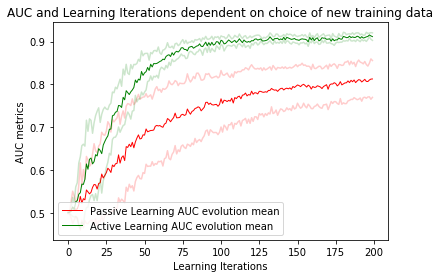

In [56]:
visualize_two_auc_evolutions(random_forest_random_sampling_results, random_forest_false_positive_sampling_results)

### Feed Forward NN Results and Visualization

In [6]:
#Random acquisition function 
feed_forward_nn_random_sampling_results = api.get_model_results({"model": "feed_forward_nn_fast_text_embeddings", "acquisition_function": "random"})
feed_forward_nn_random_sampling_results = [item for val in feed_forward_nn_random_sampling_results for item in val["results"]]

#Entropy acquisition function
feed_forward_nn_false_positive_sampling_results = api.get_model_results({"model": "feed_forward_nn_fast_text_embeddings", "acquisition_function": "false_positive_sampling"})
feed_forward_nn_false_positive_sampling_results = [item for val in feed_forward_nn_false_positive_sampling_results for item in val["results"]]

#we use zero index because database returns list even if it is only one element in list

#### Visualization

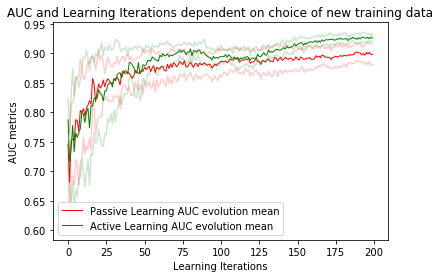

In [7]:
visualize_two_auc_evolutions(feed_forward_nn_random_sampling_results, feed_forward_nn_entropy_sampling_results)